# Active Learning

In [23]:
%load_ext autoreload
%autoreload 2

GLB_USE_DRIVE_ACCOUNT = True
GLB_INSTALL_DEPENDENCIES = True

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if GLB_USE_DRIVE_ACCOUNT:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/"Colab Notebooks"
  username = "IsaacOlguin"
  repository =  "AutomatedTraumaDetectionInGCT"
  %cd {repository}
  %pwd

if GLB_INSTALL_DEPENDENCIES:
    !pip install transformers
    #!pip install torch
    #!pip install openpyxl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/AutomatedTraumaDetectionInGCT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Execution of the **active learning**

In [28]:
!python /content/drive/MyDrive/"Colab Notebooks"/AutomatedTraumaDetectionInGCT/src/active_learning.py

DEBUG:__main__:Reading directory path
DEBUG:__main__:{'google_drive_friendly': True, 'general_set_up': {'dataset_filename': '20230112_Dataset_W_Batch1.xlsx', 'input_dir_name': 'input', 'output_dir_name': 'output', 'dataset_dir_name': 'dataset', 'logs_dir_name': 'logs', 'models_dir_name': 'models'}, 'dataset': {'index_columns_dataset': 0, 'list_columns_names': ['id_document', 'id_annotation', 'start', 'span', 'role', 'trauma', 'court', 'Comments1', 'Comments2'], 'col_of_interest_binary_classif': 'trauma', 'col_of_interest_multi_label_classif': 'role', 'col_of_reference_binary_classif': 'span', 'col_of_reference_multi_label_classif': 'span'}, 'training_model': {'epochs': 3, 'batch_size': 8, 'embedding_size': 512, 'return_attention_mask': True, 'cross_validation': False, 'save_model': False, 'store_statistics': True, 'test_model': False, 'add_special_tokes': True, 'max_length': 512, 'pad_to_max_length': True, 'run_in_gpu': True, 'classification_task': 'binary'}, 'active_training': {'size_

# Statistics analysis

In [ ]:
def get_df_statistics_set_up(json_statistics, json_setup):  
  df_statistics = None
  for index, (json_obj, set_up) in enumerate(zip(json_statistics, json_setup)):
    df_aux_stats = pd.DataFrame(json_obj)
    df_aux_stats["index"] = index

    df_aux_setup = pd.DataFrame(set_up)
    df_aux_setup.reset_index(drop=True)

    df_aux_stats = pd.concat([df_aux_stats, df_aux_setup], axis=1)
    df_aux_stats.fillna(method='ffill', inplace=True)

    if index == 0:
      df_statistics = df_aux_stats
    else:
      df_statistics = pd.concat([df_statistics, df_aux_stats])
  df_statistics.reset_index(drop=True)
  df_statistics.set_index('index', inplace=True)
  return df_statistics.reset_index()

"""
  best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
"""
def draw_statistics_spec_epoch(df, columns_of_interest, epoch=None, _index=None, size_x=15, size_y=10, _dpi=80, _loc="best",
                               withLabelsInPlot=False, _title="", showPlot=True, showScatter=True):
  fig = plt.figure(figsize=(size_x, size_y), dpi=_dpi)
  for col in columns_of_interest:
    if epoch != None:
      df_aux = df[df["epoch"] == epoch][col]
    elif _index != None:
      df_aux = df[df["index"] == _index][col]
    else:
      print("ERROR - no epoch or index given")
      return None
    
    if showPlot == False and showScatter == False:
      plt.plot(np.arange(len(df_aux)), df_aux)
      plt.scatter(np.arange(len(df_aux)), df_aux)
    elif showPlot == False:
      plt.scatter(np.arange(len(df_aux)), df_aux)
    elif showScatter == False:
      plt.plot(np.arange(len(df_aux)), df_aux)
    else:
      plt.plot(np.arange(len(df_aux)), df_aux)

    if withLabelsInPlot == True:
      for x, y in zip(np.arange(len(df_aux)), list(df_aux)):
        plt.text(x, y, str(round(y, 4)))
  plt.title(_title)
  plt.legend(columns_of_interest, loc=_loc)

## 5-split dataset

In [ ]:
_5_split_dataset_statistics = [
    [{'epoch': 1, 'Training Loss': 0.6419800456968092, 'Training Accur.': 0.6529492691980211, 'Training Precision (macro)': 0.4803452778640298, 'Training Precision (micro)': 0.6529492691980211, 'Training Recall (macro)': 0.40810856254330047, 'Training Recall (micro)': 0.6529492691980211, 'Training F1 (macro)': 0.40738512984308467, 'Training F1 (micro)': 0.6529492691980211, 'Valid. Loss': 0.293844816365069, 'Valid. Accur.': 0.924731182795699, 'Valid. Precision (macro)': 0.7673270433707888, 'Valid. Precision (micro)': 0.9244763434370102, 'Valid. Recall (macro)': 0.7866398922055351, 'Valid. Recall (micro)': 0.9244763434370102, 'Valid. F1 (macro)': 0.7693962022437939, 'Valid. F1 (micro)': 0.9244763434370102, 'Training Time': '0:03:23', 'Validation Time': '0:00:08'}, {'epoch': 2, 'Training Loss': 0.23150285094764916, 'Training Accur.': 0.9351858049194429, 'Training Precision (macro)': 0.8193741144621107, 'Training Precision (micro)': 0.9351858049194429, 'Training Recall (macro)': 0.8103580202632313, 'Training Recall (micro)': 0.9351858049194429, 'Training F1 (macro)': 0.8113421314473519, 'Training F1 (micro)': 0.9351858049194429, 'Valid. Loss': 0.2587809184145543, 'Valid. Accur.': 0.9395161290322581, 'Valid. Precision (macro)': 0.9507192695990788, 'Valid. Precision (micro)': 0.935470410114026, 'Valid. Recall (macro)': 0.8353729350566251, 'Valid. Recall (micro)': 0.935470410114026, 'Valid. F1 (macro)': 0.8504930855621397, 'Valid. F1 (micro)': 0.935470410114026, 'Training Time': '0:03:23', 'Validation Time': '0:00:08'}, {'epoch': 3, 'Training Loss': 0.171843128609761, 'Training Accur.': 0.9542518393197146, 'Training Precision (macro)': 0.9587220526447716, 'Training Precision (micro)': 0.9542518393197146, 'Training Recall (macro)': 0.8615503582661395, 'Training Recall (micro)': 0.9542518393197146, 'Training F1 (macro)': 0.8757955868537757, 'Training F1 (micro)': 0.9542518393197146, 'Valid. Loss': 0.22396792244586733, 'Valid. Accur.': 0.9435483870967742, 'Valid. Precision (macro)': 0.8311755454932185, 'Valid. Precision (micro)': 0.9120011984089742, 'Valid. Recall (macro)': 0.7809731433489672, 'Valid. Recall (micro)': 0.9120011984089742, 'Valid. F1 (macro)': 0.7892246252025439, 'Valid. F1 (micro)': 0.9120011984089742, 'Training Time': '0:03:23', 'Validation Time': '0:00:08'}],
    [{'epoch': 1, 'Training Loss': 0.5421109391929029, 'Training Accur.': 0.765749263785497, 'Training Precision (macro)': 0.5255044351505015, 'Training Precision (micro)': 0.765749263785497, 'Training Recall (macro)': 0.48306915332487277, 'Training Recall (micro)': 0.765749263785497, 'Training F1 (macro)': 0.4721171026716908, 'Training F1 (micro)': 0.765749263785497, 'Valid. Loss': 0.2935747887756004, 'Valid. Accur.': 0.9180327868852459, 'Valid. Precision (macro)': 0.7665290088426432, 'Valid. Precision (micro)': 0.9097262715547887, 'Valid. Recall (macro)': 0.7085298059101803, 'Valid. Recall (micro)': 0.9097262715547887, 'Valid. F1 (macro)': 0.707357602677676, 'Valid. F1 (micro)': 0.9097262715547887, 'Training Time': '0:06:48', 'Validation Time': '0:00:16'}, {'epoch': 2, 'Training Loss': 0.25715646729037, 'Training Accur.': 0.9272220042058863, 'Training Precision (macro)': 0.9006794260603073, 'Training Precision (micro)': 0.9272220042058863, 'Training Recall (macro)': 0.7623987767817565, 'Training Recall (micro)': 0.9272220042058863, 'Training F1 (macro)': 0.7738204716316212, 'Training F1 (micro)': 0.9272220042058863, 'Valid. Loss': 0.2526587450105819, 'Valid. Accur.': 0.9241803278688525, 'Valid. Precision (macro)': 0.8428737910659012, 'Valid. Precision (micro)': 0.9354817044279922, 'Valid. Recall (macro)': 0.8369869124853286, 'Valid. Recall (micro)': 0.9354817044279922, 'Valid. F1 (macro)': 0.8371645073247556, 'Valid. F1 (micro)': 0.9354817044279922, 'Training Time': '0:06:47', 'Validation Time': '0:00:17'}, {'epoch': 3, 'Training Loss': 0.15065730004279274, 'Training Accur.': 0.9567057358620757, 'Training Precision (macro)': 0.9322988221438004, 'Training Precision (micro)': 0.9567057358620757, 'Training Recall (macro)': 0.8783498740673982, 'Training Recall (micro)': 0.9567057358620757, 'Training F1 (macro)': 0.8988216816599333, 'Training F1 (micro)': 0.9567057358620757, 'Valid. Loss': 0.18044597319075378, 'Valid. Accur.': 0.9610655737704918, 'Valid. Precision (macro)': 0.9192325399415963, 'Valid. Precision (micro)': 0.9584350341929634, 'Valid. Recall (macro)': 0.907087740061095, 'Valid. Recall (micro)': 0.9584350341929634, 'Valid. F1 (macro)': 0.9077226430000105, 'Valid. F1 (micro)': 0.9584350341929634, 'Training Time': '0:06:47', 'Validation Time': '0:00:16'}],
    [{'epoch': 1, 'Training Loss': 0.44718275459708423, 'Training Accur.': 0.7965150235092895, 'Training Precision (macro)': 0.6062450142793518, 'Training Precision (micro)': 0.7965150235092895, 'Training Recall (macro)': 0.5217693539201322, 'Training Recall (micro)': 0.7965150235092895, 'Training F1 (macro)': 0.5173788326653822, 'Training F1 (micro)': 0.7965150235092895, 'Valid. Loss': 0.263053006062714, 'Valid. Accur.': 0.9271978021978022, 'Valid. Precision (macro)': 0.9176088911036591, 'Valid. Precision (micro)': 0.9290969796474323, 'Valid. Recall (macro)': 0.7823638526465961, 'Valid. Recall (micro)': 0.9290969796474323, 'Valid. F1 (macro)': 0.8147515307301555, 'Valid. F1 (micro)': 0.9290969796474323, 'Training Time': '0:10:15', 'Validation Time': '0:00:25'}, {'epoch': 2, 'Training Loss': 0.23386252128535606, 'Training Accur.': 0.9363765816882961, 'Training Precision (macro)': 0.9051517169401055, 'Training Precision (micro)': 0.9363765816882961, 'Training Recall (macro)': 0.819199787866392, 'Training Recall (micro)': 0.9363765816882961, 'Training F1 (macro)': 0.843982180742064, 'Training F1 (micro)': 0.9363765816882961, 'Valid. Loss': 0.19144455130867005, 'Valid. Accur.': 0.945054945054945, 'Valid. Precision (macro)': 0.8966200043599314, 'Valid. Precision (micro)': 0.9455300667027443, 'Valid. Recall (macro)': 0.858414421288408, 'Valid. Recall (micro)': 0.9455300667027443, 'Valid. F1 (macro)': 0.8705291852954217, 'Valid. F1 (micro)': 0.9455300667027443, 'Training Time': '0:10:14', 'Validation Time': '0:00:25'}, {'epoch': 3, 'Training Loss': 0.12414113029619277, 'Training Accur.': 0.9700076922175158, 'Training Precision (macro)': 0.9587739351814855, 'Training Precision (micro)': 0.9700076922175158, 'Training Recall (macro)': 0.9122562285214775, 'Training Recall (micro)': 0.9700076922175158, 'Training F1 (macro)': 0.9312806466194418, 'Training F1 (micro)': 0.9700076922175158, 'Valid. Loss': 0.25387997107687765, 'Valid. Accur.': 0.945054945054945, 'Valid. Precision (macro)': 0.923234648501772, 'Valid. Precision (micro)': 0.9494032658794055, 'Valid. Recall (macro)': 0.8581272201548519, 'Valid. Recall (micro)': 0.9494032658794055, 'Valid. F1 (macro)': 0.8778630717592018, 'Valid. F1 (micro)': 0.9494032658794055, 'Training Time': '0:10:15', 'Validation Time': '0:00:25'}],
    [{'epoch': 1, 'Training Loss': 0.4292692149317254, 'Training Accur.': 0.8062644770861854, 'Training Precision (macro)': 0.6380204392899647, 'Training Precision (micro)': 0.8062644770861854, 'Training Recall (macro)': 0.5496480545637542, 'Training Recall (micro)': 0.8062644770861854, 'Training F1 (macro)': 0.5496936818774638, 'Training F1 (micro)': 0.8062644770861854, 'Valid. Loss': 0.2336193000531343, 'Valid. Accur.': 0.9211065573770492, 'Valid. Precision (macro)': 0.8177382416172905, 'Valid. Precision (micro)': 0.9236049951982145, 'Valid. Recall (macro)': 0.800402819885766, 'Valid. Recall (micro)': 0.9236049951982145, 'Valid. F1 (macro)': 0.7803253533991817, 'Valid. F1 (micro)': 0.9236049951982145, 'Training Time': '0:13:43', 'Validation Time': '0:00:33'}, {'epoch': 2, 'Training Loss': 0.21480739059185971, 'Training Accur.': 0.9419572730077427, 'Training Precision (macro)': 0.897541947760697, 'Training Precision (micro)': 0.9419572730077427, 'Training Recall (macro)': 0.8437873194063173, 'Training Recall (micro)': 0.9419572730077427, 'Training F1 (macro)': 0.8608150102843005, 'Training F1 (micro)': 0.9419572730077427, 'Valid. Loss': 0.1975588304616633, 'Valid. Accur.': 0.9456967213114754, 'Valid. Precision (macro)': 0.9241802734862166, 'Valid. Precision (micro)': 0.9458195123083307, 'Valid. Recall (macro)': 0.8564708201117797, 'Valid. Recall (micro)': 0.9458195123083307, 'Valid. F1 (macro)': 0.8814379502246114, 'Valid. F1 (micro)': 0.9458195123083307, 'Training Time': '0:13:43', 'Validation Time': '0:00:33'}, {'epoch': 3, 'Training Loss': 0.13831999245188847, 'Training Accur.': 0.9614585823997986, 'Training Precision (macro)': 0.9438433990271274, 'Training Precision (micro)': 0.9614585823997986, 'Training Recall (macro)': 0.8998926029405547, 'Training Recall (micro)': 0.9614585823997986, 'Training F1 (macro)': 0.9178204773502074, 'Training F1 (micro)': 0.9614585823997986, 'Valid. Loss': 0.18438732746862577, 'Valid. Accur.': 0.9528688524590164, 'Valid. Precision (macro)': 0.9219830458585176, 'Valid. Precision (micro)': 0.9569436928002619, 'Valid. Recall (macro)': 0.9285371064078578, 'Valid. Recall (micro)': 0.9569436928002619, 'Valid. F1 (macro)': 0.9206582144828067, 'Valid. F1 (micro)': 0.9569436928002619, 'Training Time': '0:13:42', 'Validation Time': '0:00:33'}],
    [{'epoch': 1, 'Training Loss': 0.3996505447701547, 'Training Accur.': 0.8239347351244178, 'Training Precision (macro)': 0.683821525652662, 'Training Precision (micro)': 0.8239347351244178, 'Training Recall (macro)': 0.5745601426823458, 'Training Recall (micro)': 0.8239347351244178, 'Training F1 (macro)': 0.5766569149467256, 'Training F1 (micro)': 0.8239347351244178, 'Valid. Loss': 0.23345147260452473, 'Valid. Accur.': 0.9347587719298246, 'Valid. Precision (macro)': 0.887484591847227, 'Valid. Precision (micro)': 0.9311728725119565, 'Valid. Recall (macro)': 0.7946178563863263, 'Valid. Recall (micro)': 0.9311728725119565, 'Valid. F1 (macro)': 0.8162664878640236, 'Valid. F1 (micro)': 0.9311728725119565, 'Training Time': '0:17:15', 'Validation Time': '0:00:41'}, {'epoch': 2, 'Training Loss': 0.20379231723138277, 'Training Accur.': 0.9447177657617155, 'Training Precision (macro)': 0.8999053151506428, 'Training Precision (micro)': 0.9447177657617155, 'Training Recall (macro)': 0.8527582375281435, 'Training Recall (micro)': 0.9447177657617155, 'Training F1 (macro)': 0.8694489220259981, 'Training F1 (micro)': 0.9447177657617155, 'Valid. Loss': 0.23929256887793982, 'Valid. Accur.': 0.9432565789473685, 'Valid. Precision (macro)': 0.9076979714987007, 'Valid. Precision (micro)': 0.9489700028380335, 'Valid. Recall (macro)': 0.8551161724640364, 'Valid. Recall (micro)': 0.9489700028380335, 'Valid. F1 (macro)': 0.8646730885990294, 'Valid. F1 (micro)': 0.9489700028380335, 'Training Time': '0:17:15', 'Validation Time': '0:00:41'}, {'epoch': 3, 'Training Loss': 0.1300524215867704, 'Training Accur.': 0.9673970367433907, 'Training Precision (macro)': 0.9493803201172045, 'Training Precision (micro)': 0.9673970367433907, 'Training Recall (macro)': 0.9256453843986068, 'Training Recall (micro)': 0.9673970367433907, 'Training F1 (macro)': 0.935014371548432, 'Training F1 (micro)': 0.9673970367433907, 'Valid. Loss': 0.21885956326973668, 'Valid. Accur.': 0.9555921052631579, 'Valid. Precision (macro)': 0.937712940164691, 'Valid. Precision (micro)': 0.9559274640913946, 'Valid. Recall (macro)': 0.8540510305938664, 'Valid. Recall (micro)': 0.9559274640913946, 'Valid. F1 (macro)': 0.8787559822671416, 'Valid. F1 (micro)': 0.9559274640913946, 'Training Time': '0:17:15', 'Validation Time': '0:00:41'}]
]
_5_split_set_up_models = [
    [{'size_batches':8, 'num_batches_training': 273, 'size_training': 2183, 'size_validation': 243, 'size_test': 128}],
    [{'size_batches':8, 'num_batches_training': 546, 'size_training': 4366, 'size_validation': 486, 'size_test': 256}],
    [{'size_batches':8, 'num_batches_training': 819, 'size_training': 6550, 'size_validation': 728, 'size_test': 384}],
    [{'size_batches':8, 'num_batches_training': 1092, 'size_training': 8734, 'size_validation': 971, 'size_test': 511}],
    [{'size_batches':8, 'num_batches_training': 1366, 'size_training': 10923, 'size_validation': 1214, 'size_test': 639}]
]
print(len(_5_split_dataset_statistics))

5


In [ ]:
df_5_split = get_df_statistics_set_up(_5_split_dataset_statistics, _5_split_set_up_models)
df_5_split

,index,epoch,Training Loss,Training Accur.,Training Precision (macro),Training Precision (micro),Training Recall (macro),Training Recall (micro),Training F1 (macro),Training F1 (micro),...,Valid. Recall (micro),Valid. F1 (macro),Valid. F1 (micro),Training Time,Validation Time,size_batches,num_batches_training,size_training,size_validation,size_test
0,0,1,0.641980,0.652949,0.480345,0.652949,0.408109,0.652949,0.407385,0.652949,...,0.924476,0.769396,0.924476,0:03:23,0:00:08,8.0,273.0,2183.0,243.0,128.0
1,0,2,0.231503,0.935186,0.819374,0.935186,0.810358,0.935186,0.811342,0.935186,...,0.935470,0.850493,0.935470,0:03:23,0:00:08,8.0,273.0,2183.0,243.0,128.0
2,0,3,0.171843,0.954252,0.958722,0.954252,0.861550,0.954252,0.875796,0.954252,...,0.912001,0.789225,0.912001,0:03:23,0:00:08,8.0,273.0,2183.0,243.0,128.0
3,1,1,0.542111,0.765749,0.525504,0.765749,0.483069,0.765749,0.472117,0.765749,...,0.909726,0.707358,0.909726,0:06:48,0:00:16,8.0,546.0,4366.0,486.0,256.0
4,1,2,0.257156,0.927222,0.900679,0.927222,0.762399,0.927222,0.773820,0.927222,...,0.935482,0.837165,0.935482,0:06:47,0:00:17,8.0,546.0,4366.0,486.0,256.0
5,1,3,0.150657,0.956706,0.932299,0.956706,0.878350,0.956706,0.898822,0.956706,...,0.958435,0.907723,0.958435,0:06:47,0:00:16,8.0,546.0,4366.0,486.0,256.0
6,2,1,0.447183,0.796515,0.606245,0.796515,0.521769,0.796515,0.517379,0.796515,...,0.929097,0.814752,0.929097,0:10:15,0:00:25,8.0,819.0,6550.0,728.0,384.0
7,2,2,0.233863,0.936377,0.905152,0.936377,0.819200,0.936377,0.843982,0.936377,...,0.945530,0.870529,0.945530,0:10:14,0:00:25,8.0,819.0,6550.0,728.0,384.0
8,2,3,0.124141,0.970008,0.958774,0.970008,0.912256,0.970008,0.931281,0.970008,...,0.949403,0.877863,0.949403,0:10:15,0:00:25,8.0,819.0,6550.0,728.0,384.0
9,3,1,0.429269,0.806264,0.638020,0.806264,0.549648,0.806264,0.549694,0.806264,...,0.923605,0.780325,0.923605,0:13:43,0:00:33,8.0,1092.0,8734.0,971.0,511.0


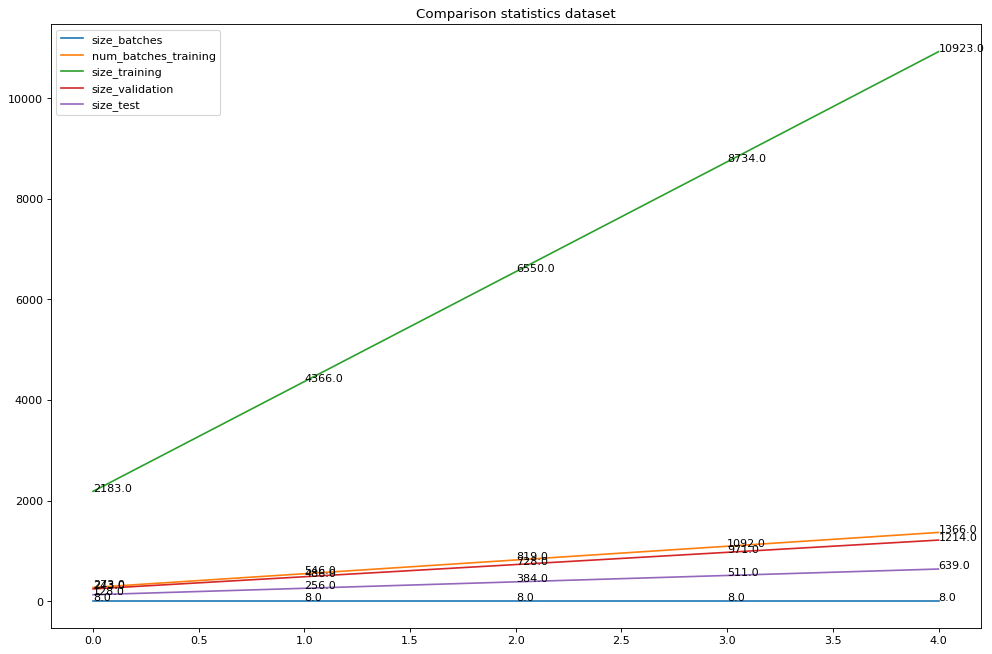

In [ ]:
#df_5_split.columns
columns_of_interest = ["size_batches", "num_batches_training", "size_training", 
                       "size_validation", "size_test"]
draw_statistics_spec_epoch(df_5_split, columns_of_interest, epoch=3, 
                           withLabelsInPlot=True, _title="Comparison statistics dataset",
                           showPlot=True, showScatter=True)

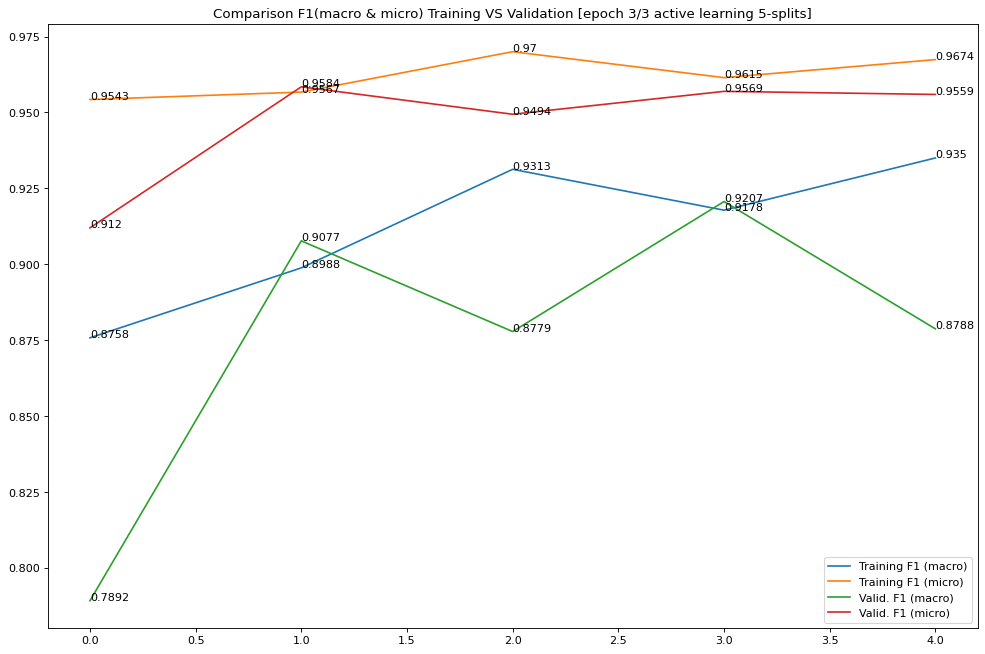

In [ ]:
columns_of_interest = ["Training F1 (macro)", "Training F1 (micro)",
                       "Valid. F1 (macro)", "Valid. F1 (micro)"]

draw_statistics_spec_epoch(df_5_split, columns_of_interest, epoch=3, 
                           withLabelsInPlot=True, _loc="lower right", 
                           showPlot=True, showScatter=True,
                           _title="Comparison F1(macro & micro) Training VS Validation [epoch 3/3 active learning 5-splits]")

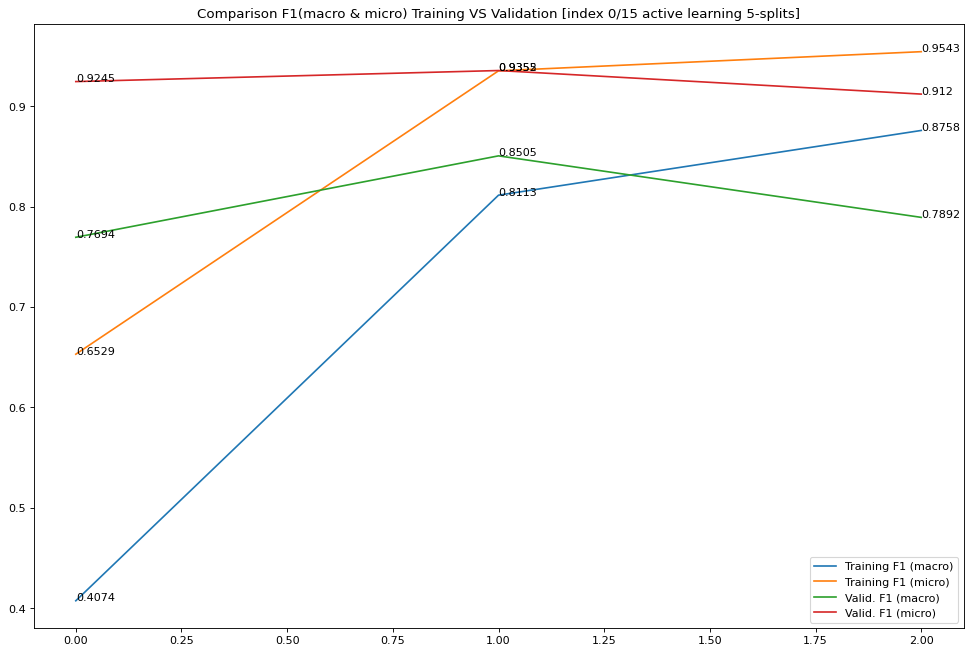

In [ ]:
columns_of_interest = ["Training F1 (macro)", "Training F1 (micro)",
                       "Valid. F1 (macro)", "Valid. F1 (micro)"]
__index = 0
draw_statistics_spec_epoch(df_5_split, columns_of_interest, _index=__index, 
                           withLabelsInPlot=True, _loc="lower right", 
                           showPlot=True, showScatter=True,
                           _title=f"Comparison F1(macro & micro) Training VS Validation [index {__index}/{len(df_5_split)} active learning 5-splits]")

## 10-split dataset

In [ ]:
_10_split_dataset_statistics = [
    [{'epoch': 1, 'Training Loss': 0.8046261788937297, 'Training Accur.': 0.6329436274754553, 'Training Precision (macro)': 0.49327005259078177, 'Training Precision (micro)': 0.6329436274754553, 'Training Recall (macro)': 0.3697085930597474, 'Training Recall (micro)': 0.6329436274754553, 'Training F1 (macro)': 0.35936612547461755, 'Training F1 (micro)': 0.6329436274754553, 'Valid. Loss': 0.3802322333212942, 'Valid. Accur.': 0.8828125, 'Valid. Precision (macro)': 0.6553245275682887, 'Valid. Precision (micro)': 0.8648505474773406, 'Valid. Recall (macro)': 0.6623328804132377, 'Valid. Recall (micro)': 0.8648505474773406, 'Valid. F1 (macro)': 0.6489992920428729, 'Valid. F1 (micro)': 0.8648505474773406, 'Training Time': '0:01:36', 'Validation Time': '0:00:04'}, {'epoch': 2, 'Training Loss': 0.28027145807923626, 'Training Accur.': 0.9089782951201365, 'Training Precision (macro)': 0.8804228970082192, 'Training Precision (micro)': 0.9089782951201365, 'Training Recall (macro)': 0.7198083263300749, 'Training Recall (micro)': 0.9089782951201365, 'Training F1 (macro)': 0.7318651218528501, 'Training F1 (micro)': 0.9089782951201365, 'Valid. Loss': 0.13534121768316254, 'Valid. Accur.': 0.96875, 'Valid. Precision (macro)': 0.9937519325912183, 'Valid. Precision (micro)': 0.9917394529138895, 'Valid. Recall (macro)': 0.9794407894736842, 'Valid. Recall (micro)': 0.9917394529138895, 'Valid. F1 (macro)': 0.9833629356697398, 'Valid. F1 (micro)': 0.9917394529138895, 'Training Time': '0:01:37', 'Validation Time': '0:00:04'}, {'epoch': 3, 'Training Loss': 0.15680644345082287, 'Training Accur.': 0.9607472066644748, 'Training Precision (macro)': 0.934639852901265, 'Training Precision (micro)': 0.9607472066644748, 'Training Recall (macro)': 0.889852686535501, 'Training Recall (micro)': 0.9607472066644748, 'Training F1 (macro)': 0.9024077974769138, 'Training F1 (micro)': 0.9607472066644748, 'Valid. Loss': 0.09447524903225712, 'Valid. Accur.': 0.984375, 'Valid. Precision (macro)': 0.9908411846993282, 'Valid. Precision (micro)': 0.9886180371740052, 'Valid. Recall (macro)': 0.9645833333333335, 'Valid. Recall (micro)': 0.9886180371740052, 'Valid. F1 (macro)': 0.9723187667609681, 'Valid. F1 (micro)': 0.9886180371740052, 'Training Time': '0:01:37', 'Validation Time': '0:00:04'}],
    [{'epoch': 1, 'Training Loss': 0.6927324393184193, 'Training Accur.': 0.6670539263627743, 'Training Precision (macro)': 0.43298629633042457, 'Training Precision (micro)': 0.6670539263627743, 'Training Recall (macro)': 0.4000671232022157, 'Training Recall (micro)': 0.6670539263627743, 'Training F1 (macro)': 0.3774019764941353, 'Training F1 (micro)': 0.6670539263627743, 'Valid. Loss': 0.31771703376885385, 'Valid. Accur.': 0.9153225806451613, 'Valid. Precision (macro)': 0.7376686671630206, 'Valid. Precision (micro)': 0.9140401058333982, 'Valid. Recall (macro)': 0.7361767622653708, 'Valid. Recall (micro)': 0.9140401058333982, 'Valid. F1 (macro)': 0.7202964106149814, 'Valid. F1 (micro)': 0.9140401058333982, 'Training Time': '0:03:14', 'Validation Time': '0:00:07'}, {'epoch': 2, 'Training Loss': 0.27411874933952923, 'Training Accur.': 0.9248169359729937, 'Training Precision (macro)': 0.8452069456290144, 'Training Precision (micro)': 0.9248169359729937, 'Training Recall (macro)': 0.7931082562261247, 'Training Recall (micro)': 0.9248169359729937, 'Training F1 (macro)': 0.7924810136795523, 'Training F1 (micro)': 0.9248169359729937, 'Valid. Loss': 0.2391077743452643, 'Valid. Accur.': 0.9408602150537635, 'Valid. Precision (macro)': 0.8142473884763909, 'Valid. Precision (micro)': 0.9355235899013183, 'Valid. Recall (macro)': 0.7918145563415646, 'Valid. Recall (micro)': 0.9355235899013183, 'Valid. F1 (macro)': 0.7826734674958906, 'Valid. F1 (micro)': 0.9355235899013183, 'Training Time': '0:03:14', 'Validation Time': '0:00:07'}, {'epoch': 3, 'Training Loss': 0.18757579782841244, 'Training Accur.': 0.9347096998822049, 'Training Precision (macro)': 0.9176564437286797, 'Training Precision (micro)': 0.9347096998822049, 'Training Recall (macro)': 0.8296472114820911, 'Training Recall (micro)': 0.9347096998822049, 'Training F1 (macro)': 0.8399555792908882, 'Training F1 (micro)': 0.9347096998822049, 'Valid. Loss': 0.2099444949248385, 'Valid. Accur.': 0.9516129032258065, 'Valid. Precision (macro)': 0.8493393044101095, 'Valid. Precision (micro)': 0.9510033176064204, 'Valid. Recall (macro)': 0.8628013819258062, 'Valid. Recall (micro)': 0.9510033176064204, 'Valid. F1 (macro)': 0.8454564352608268, 'Valid. F1 (micro)': 0.9510033176064204, 'Training Time': '0:03:14', 'Validation Time': '0:00:07'}],
    [{'epoch': 1, 'Training Loss': 0.5809740719173677, 'Training Accur.': 0.7136494010015906, 'Training Precision (macro)': 0.5204680061773745, 'Training Precision (micro)': 0.7136494010015906, 'Training Recall (macro)': 0.43608898801710055, 'Training Recall (micro)': 0.7136494010015906, 'Training F1 (macro)': 0.4164675585345025, 'Training F1 (micro)': 0.7136494010015906, 'Valid. Loss': 0.2939315936325685, 'Valid. Accur.': 0.9320652173913043, 'Valid. Precision (macro)': 0.8967657312665156, 'Valid. Precision (micro)': 0.9468268578135841, 'Valid. Recall (macro)': 0.8187391751311495, 'Valid. Recall (micro)': 0.9468268578135841, 'Valid. F1 (macro)': 0.8227165388037084, 'Valid. F1 (micro)': 0.9468268578135841, 'Training Time': '0:04:51', 'Validation Time': '0:00:11'}, {'epoch': 2, 'Training Loss': 0.24581446691500455, 'Training Accur.': 0.93110106071145, 'Training Precision (macro)': 0.930793516074059, 'Training Precision (micro)': 0.93110106071145, 'Training Recall (macro)': 0.7901183025523798, 'Training Recall (micro)': 0.93110106071145, 'Training F1 (macro)': 0.8126935946160891, 'Training F1 (micro)': 0.93110106071145, 'Valid. Loss': 0.24687667180905523, 'Valid. Accur.': 0.9347826086956522, 'Valid. Precision (macro)': 0.9500679827779248, 'Valid. Precision (micro)': 0.9436133319151416, 'Valid. Recall (macro)': 0.8638634447246877, 'Valid. Recall (micro)': 0.9436133319151416, 'Valid. F1 (macro)': 0.8765428739288808, 'Valid. F1 (micro)': 0.9436133319151416, 'Training Time': '0:04:51', 'Validation Time': '0:00:11'}, {'epoch': 3, 'Training Loss': 0.17377195079539945, 'Training Accur.': 0.9481311520620567, 'Training Precision (macro)': 0.9368658274179611, 'Training Precision (micro)': 0.9481311520620567, 'Training Recall (macro)': 0.8380277141495415, 'Training Recall (micro)': 0.9481311520620567, 'Training F1 (macro)': 0.8681621083488625, 'Training F1 (micro)': 0.9481311520620567, 'Valid. Loss': 0.29439490346450603, 'Valid. Accur.': 0.9320652173913043, 'Valid. Precision (macro)': 0.8857749899782236, 'Valid. Precision (micro)': 0.9409981310152532, 'Valid. Recall (macro)': 0.8545497605252181, 'Valid. Recall (micro)': 0.9409981310152532, 'Valid. F1 (macro)': 0.8616990923685913, 'Valid. F1 (micro)': 0.9409981310152532, 'Training Time': '0:04:51', 'Validation Time': '0:00:11'}],
    [{'epoch': 1, 'Training Loss': 0.528647424832273, 'Training Accur.': 0.7513125671590168, 'Training Precision (macro)': 0.5618995427558174, 'Training Precision (micro)': 0.7513125671590168, 'Training Recall (macro)': 0.48524275902080455, 'Training Recall (micro)': 0.7513125671590168, 'Training F1 (macro)': 0.4729630396107041, 'Training F1 (micro)': 0.7513125671590168, 'Valid. Loss': 0.3174797688900936, 'Valid. Accur.': 0.9159836065573771, 'Valid. Precision (macro)': 0.788980188175161, 'Valid. Precision (micro)': 0.9100626930807373, 'Valid. Recall (macro)': 0.7351413024313453, 'Valid. Recall (micro)': 0.9100626930807373, 'Valid. F1 (macro)': 0.7422225961547477, 'Valid. F1 (micro)': 0.9100626930807373, 'Training Time': '0:06:28', 'Validation Time': '0:00:15'}, {'epoch': 2, 'Training Loss': 0.2688371947507678, 'Training Accur.': 0.9231343541281042, 'Training Precision (macro)': 0.8917351167972373, 'Training Precision (micro)': 0.9231343541281042, 'Training Recall (macro)': 0.7667648475516851, 'Training Recall (micro)': 0.9231343541281042, 'Training F1 (macro)': 0.7864897657593956, 'Training F1 (micro)': 0.9231343541281042, 'Valid. Loss': 0.27101168547161536, 'Valid. Accur.': 0.930327868852459, 'Valid. Precision (macro)': 0.8599343188024096, 'Valid. Precision (micro)': 0.9505615658484438, 'Valid. Recall (macro)': 0.7930259046218776, 'Valid. Recall (micro)': 0.9505615658484438, 'Valid. F1 (macro)': 0.8065894374136275, 'Valid. F1 (micro)': 0.9505615658484438, 'Training Time': '0:06:28', 'Validation Time': '0:00:15'}, {'epoch': 3, 'Training Loss': 0.18363987712015573, 'Training Accur.': 0.9481356652610429, 'Training Precision (macro)': 0.9240318461648827, 'Training Precision (micro)': 0.9481356652610429, 'Training Recall (macro)': 0.8375425938122337, 'Training Recall (micro)': 0.9481356652610429, 'Training F1 (macro)': 0.8650444802278054, 'Training F1 (micro)': 0.9481356652610429, 'Valid. Loss': 0.19849188056140832, 'Valid. Accur.': 0.944672131147541, 'Valid. Precision (macro)': 0.897773479501386, 'Valid. Precision (micro)': 0.946260279582508, 'Valid. Recall (macro)': 0.8418661338037786, 'Valid. Recall (micro)': 0.946260279582508, 'Valid. F1 (macro)': 0.8605336590196104, 'Valid. F1 (micro)': 0.946260279582508, 'Training Time': '0:06:28', 'Validation Time': '0:00:15'}],
    [{'epoch': 1, 'Training Loss': 0.46577861861809217, 'Training Accur.': 0.7912077418823027, 'Training Precision (macro)': 0.6170144422926205, 'Training Precision (micro)': 0.7912077418823027, 'Training Recall (macro)': 0.5186577892467189, 'Training Recall (micro)': 0.7912077418823027, 'Training F1 (macro)': 0.5176190495300034, 'Training F1 (micro)': 0.7912077418823027, 'Valid. Loss': 0.22705284148258598, 'Valid. Accur.': 0.930921052631579, 'Valid. Precision (macro)': 0.8440089453194867, 'Valid. Precision (micro)': 0.9332988376184864, 'Valid. Recall (macro)': 0.8022713904376901, 'Valid. Recall (micro)': 0.9332988376184864, 'Valid. F1 (macro)': 0.8036086095282995, 'Valid. F1 (micro)': 0.9332988376184864, 'Training Time': '0:08:06', 'Validation Time': '0:00:19'}, {'epoch': 2, 'Training Loss': 0.2302630424241418, 'Training Accur.': 0.9326502294655419, 'Training Precision (macro)': 0.9038469530754832, 'Training Precision (micro)': 0.9326502294655419, 'Training Recall (macro)': 0.7992474933505268, 'Training Recall (micro)': 0.9326502294655419, 'Training F1 (macro)': 0.8239615460503656, 'Training F1 (micro)': 0.9326502294655419, 'Valid. Loss': 0.20788977578080162, 'Valid. Accur.': 0.9473684210526315, 'Valid. Precision (macro)': 0.896094384742848, 'Valid. Precision (micro)': 0.9429720153794876, 'Valid. Recall (macro)': 0.8386802224046189, 'Valid. Recall (micro)': 0.9429720153794876, 'Valid. F1 (macro)': 0.8550387361631139, 'Valid. F1 (micro)': 0.9429720153794876, 'Training Time': '0:08:06', 'Validation Time': '0:00:19'}, {'epoch': 3, 'Training Loss': 0.1376349004860346, 'Training Accur.': 0.9613233496890135, 'Training Precision (macro)': 0.9375098633724686, 'Training Precision (micro)': 0.9613233496890135, 'Training Recall (macro)': 0.8934132632327847, 'Training Recall (micro)': 0.9613233496890135, 'Training F1 (macro)': 0.9104176605921742, 'Training F1 (micro)': 0.9613233496890135, 'Valid. Loss': 0.24817440498430332, 'Valid. Accur.': 0.9504229323308271, 'Valid. Precision (macro)': 0.931949366503396, 'Valid. Precision (micro)': 0.9535023427610417, 'Valid. Recall (macro)': 0.84656049088685, 'Valid. Recall (micro)': 0.9535023427610417, 'Valid. F1 (macro)': 0.8758480074680672, 'Valid. F1 (micro)': 0.9535023427610417, 'Training Time': '0:08:06', 'Validation Time': '0:00:19'}],
    [{'epoch': 1, 'Training Loss': 0.45156140496240194, 'Training Accur.': 0.7927388339487328, 'Training Precision (macro)': 0.6354641231206603, 'Training Precision (micro)': 0.7927388339487328, 'Training Recall (macro)': 0.5228966099504211, 'Training Recall (micro)': 0.7927388339487328, 'Training F1 (macro)': 0.5193915384417449, 'Training F1 (micro)': 0.7927388339487328, 'Valid. Loss': 0.34621056895907765, 'Valid. Accur.': 0.907967032967033, 'Valid. Precision (macro)': 0.8810037499448767, 'Valid. Precision (micro)': 0.9025733413385216, 'Valid. Recall (macro)': 0.7215686814492648, 'Valid. Recall (micro)': 0.9025733413385216, 'Valid. F1 (macro)': 0.7337156732920596, 'Valid. F1 (micro)': 0.9025733413385216, 'Training Time': '0:09:45', 'Validation Time': '0:00:22'}, {'epoch': 2, 'Training Loss': 0.22118026083656525, 'Training Accur.': 0.9397451000725635, 'Training Precision (macro)': 0.9231528992671668, 'Training Precision (micro)': 0.9397451000725635, 'Training Recall (macro)': 0.8224824211867325, 'Training Recall (micro)': 0.9397451000725635, 'Training F1 (macro)': 0.8528641220023688, 'Training F1 (micro)': 0.9397451000725635, 'Valid. Loss': 0.2843530786269764, 'Valid. Accur.': 0.9340659340659341, 'Valid. Precision (macro)': 0.9037730960912678, 'Valid. Precision (micro)': 0.9327266865763513, 'Valid. Recall (macro)': 0.8100584168860004, 'Valid. Recall (micro)': 0.9327266865763513, 'Valid. F1 (macro)': 0.8293698407793376, 'Valid. F1 (micro)': 0.9327266865763513, 'Training Time': '0:09:44', 'Validation Time': '0:00:22'}, {'epoch': 3, 'Training Loss': 0.13284868496575056, 'Training Accur.': 0.9672638274937111, 'Training Precision (macro)': 0.9550574736244333, 'Training Precision (micro)': 0.9672638274937111, 'Training Recall (macro)': 0.914691465192843, 'Training Recall (micro)': 0.9672638274937111, 'Training F1 (macro)': 0.9311756491857289, 'Training F1 (micro)': 0.9672638274937111, 'Valid. Loss': 0.3496089986260663, 'Valid. Accur.': 0.9313186813186813, 'Valid. Precision (macro)': 0.9069680749240147, 'Valid. Precision (micro)': 0.9166798902308869, 'Valid. Recall (macro)': 0.7336751118811046, 'Valid. Recall (micro)': 0.9166798902308869, 'Valid. F1 (macro)': 0.7715540637195866, 'Valid. F1 (micro)': 0.9166798902308869, 'Training Time': '0:09:44', 'Validation Time': '0:00:22'}],
    [{'epoch': 1, 'Training Loss': 0.44906452907181066, 'Training Accur.': 0.7901025210314425, 'Training Precision (macro)': 0.6125584230598551, 'Training Precision (micro)': 0.7901025210314425, 'Training Recall (macro)': 0.5282205420367289, 'Training Recall (micro)': 0.7901025210314425, 'Training F1 (macro)': 0.5262506770376343, 'Training F1 (micro)': 0.7901025210314425, 'Valid. Loss': 0.24490652666057278, 'Valid. Accur.': 0.9158878504672897, 'Valid. Precision (macro)': 0.8206310929134546, 'Valid. Precision (micro)': 0.9059569360615642, 'Valid. Recall (macro)': 0.7050417386756809, 'Valid. Recall (micro)': 0.9059569360615642, 'Valid. F1 (macro)': 0.7246359820735119, 'Valid. F1 (micro)': 0.9059569360615642, 'Training Time': '0:11:24', 'Validation Time': '0:00:26'}, {'epoch': 2, 'Training Loss': 0.22296788667947912, 'Training Accur.': 0.9384213027288455, 'Training Precision (macro)': 0.9197755588734444, 'Training Precision (micro)': 0.9384213027288455, 'Training Recall (macro)': 0.8155199100879531, 'Training Recall (micro)': 0.9384213027288455, 'Training F1 (macro)': 0.8458734662889263, 'Training F1 (micro)': 0.9384213027288455, 'Valid. Loss': 0.2028366182680529, 'Valid. Accur.': 0.9450934579439252, 'Valid. Precision (macro)': 0.9321047805818494, 'Valid. Precision (micro)': 0.951107860440893, 'Valid. Recall (macro)': 0.8633294231611616, 'Valid. Recall (micro)': 0.951107860440893, 'Valid. F1 (macro)': 0.8888458530220622, 'Valid. F1 (micro)': 0.951107860440893, 'Training Time': '0:11:24', 'Validation Time': '0:00:26'}, {'epoch': 3, 'Training Loss': 0.13640408618802313, 'Training Accur.': 0.9677178703900507, 'Training Precision (macro)': 0.9548701047988988, 'Training Precision (micro)': 0.9677178703900507, 'Training Recall (macro)': 0.9088349668419659, 'Training Recall (micro)': 0.9677178703900507, 'Training F1 (macro)': 0.9280549294080743, 'Training F1 (micro)': 0.9677178703900507, 'Valid. Loss': 0.1959683000056778, 'Valid. Accur.': 0.9509345794392523, 'Valid. Precision (macro)': 0.9008757604224573, 'Valid. Precision (micro)': 0.9480790896968418, 'Valid. Recall (macro)': 0.8848114641603625, 'Valid. Recall (micro)': 0.9480790896968418, 'Valid. F1 (macro)': 0.8881124386251793, 'Valid. F1 (micro)': 0.9480790896968418, 'Training Time': '0:11:24', 'Validation Time': '0:00:26'}],
    [{'epoch': 1, 'Training Loss': 0.4270835539503629, 'Training Accur.': 0.8167676446415707, 'Training Precision (macro)': 0.6563272959803286, 'Training Precision (micro)': 0.8167676446415707, 'Training Recall (macro)': 0.5724435942098617, 'Training Recall (micro)': 0.8167676446415707, 'Training F1 (macro)': 0.5756150595401097, 'Training F1 (micro)': 0.8167676446415706, 'Valid. Loss': 0.2823755042799214, 'Valid. Accur.': 0.930327868852459, 'Valid. Precision (macro)': 0.8971515129333407, 'Valid. Precision (micro)': 0.9306492737118246, 'Valid. Recall (macro)': 0.7982111237359407, 'Valid. Recall (micro)': 0.9306492737118246, 'Valid. F1 (macro)': 0.8039259452912862, 'Valid. F1 (micro)': 0.9306492737118246, 'Training Time': '0:13:04', 'Validation Time': '0:00:30'}, {'epoch': 2, 'Training Loss': 0.2107948701003674, 'Training Accur.': 0.9386216055798817, 'Training Precision (macro)': 0.9007875868154935, 'Training Precision (micro)': 0.9386216055798817, 'Training Recall (macro)': 0.8315996539080318, 'Training Recall (micro)': 0.9386216055798817, 'Training F1 (macro)': 0.8540991079310154, 'Training F1 (micro)': 0.9386216055798817, 'Valid. Loss': 0.17457265691587426, 'Valid. Accur.': 0.9559426229508197, 'Valid. Precision (macro)': 0.9126622684848955, 'Valid. Precision (micro)': 0.9512240874699536, 'Valid. Recall (macro)': 0.8765163788394669, 'Valid. Recall (micro)': 0.9512240874699536, 'Valid. F1 (macro)': 0.8903887065824558, 'Valid. F1 (micro)': 0.9512240874699536, 'Training Time': '0:13:04', 'Validation Time': '0:00:30'}, {'epoch': 3, 'Training Loss': 0.1338163468588526, 'Training Accur.': 0.9643727880612828, 'Training Precision (macro)': 0.9313523556331219, 'Training Precision (micro)': 0.9643727880612828, 'Training Recall (macro)': 0.9196378899187369, 'Training Recall (micro)': 0.9643727880612828, 'Training F1 (macro)': 0.9244952971335143, 'Training F1 (micro)': 0.9643727880612828, 'Valid. Loss': 0.24695754350882526, 'Valid. Accur.': 0.9456967213114754, 'Valid. Precision (macro)': 0.909954785254482, 'Valid. Precision (micro)': 0.9561290446766457, 'Valid. Recall (macro)': 0.8686247433183937, 'Valid. Recall (micro)': 0.9561290446766457, 'Valid. F1 (macro)': 0.8834903255744043, 'Valid. F1 (micro)': 0.9561290446766457, 'Training Time': '0:13:04', 'Validation Time': '0:00:30'}],
    [{'epoch': 1, 'Training Loss': 0.40349967523852626, 'Training Accur.': 0.8233151868266183, 'Training Precision (macro)': 0.6831219730633805, 'Training Precision (micro)': 0.8233151868266183, 'Training Recall (macro)': 0.5684940470959272, 'Training Recall (micro)': 0.8233151868266183, 'Training F1 (macro)': 0.573245298925251, 'Training F1 (micro)': 0.8233151868266183, 'Valid. Loss': 0.23305951385507293, 'Valid. Accur.': 0.9333941605839416, 'Valid. Precision (macro)': 0.9264369419911418, 'Valid. Precision (micro)': 0.931255535822388, 'Valid. Recall (macro)': 0.7756039808617987, 'Valid. Recall (micro)': 0.931255535822388, 'Valid. F1 (macro)': 0.8070128977635539, 'Valid. F1 (micro)': 0.931255535822388, 'Training Time': '0:14:45', 'Validation Time': '0:00:34'}, {'epoch': 2, 'Training Loss': 0.2128037099747781, 'Training Accur.': 0.9444947729261224, 'Training Precision (macro)': 0.91699533112514, 'Training Precision (micro)': 0.9444947729261224, 'Training Recall (macro)': 0.8438744703885604, 'Training Recall (micro)': 0.9444947729261224, 'Training F1 (macro)': 0.8696890875978001, 'Training F1 (micro)': 0.9444947729261224, 'Valid. Loss': 0.22337762955202292, 'Valid. Accur.': 0.9306569343065694, 'Valid. Precision (macro)': 0.8843225334064877, 'Valid. Precision (micro)': 0.9411179458560168, 'Valid. Recall (macro)': 0.8607101362835081, 'Valid. Recall (micro)': 0.9411179458560168, 'Valid. F1 (macro)': 0.8641134465382021, 'Valid. F1 (micro)': 0.9411179458560168, 'Training Time': '0:14:44', 'Validation Time': '0:00:34'}, {'epoch': 3, 'Training Loss': 0.1317846983350667, 'Training Accur.': 0.9681479231970026, 'Training Precision (macro)': 0.9518483764353017, 'Training Precision (micro)': 0.9681479231970026, 'Training Recall (macro)': 0.9218276679327662, 'Training Recall (micro)': 0.9681479231970026, 'Training F1 (macro)': 0.935421138921836, 'Training F1 (micro)': 0.9681479231970026, 'Valid. Loss': 0.21293217595879083, 'Valid. Accur.': 0.9525547445255474, 'Valid. Precision (macro)': 0.9138334959855704, 'Valid. Precision (micro)': 0.9549806530877916, 'Valid. Recall (macro)': 0.8811482436200846, 'Valid. Recall (micro)': 0.9549806530877916, 'Valid. F1 (macro)': 0.8934687722162231, 'Valid. F1 (micro)': 0.9549806530877916, 'Training Time': '0:14:44', 'Validation Time': '0:00:34'}],
    [{'epoch': 1, 'Training Loss': 0.3996505447701547, 'Training Accur.': 0.8239347351244178, 'Training Precision (macro)': 0.683821525652662, 'Training Precision (micro)': 0.8239347351244178, 'Training Recall (macro)': 0.5745601426823458, 'Training Recall (micro)': 0.8239347351244178, 'Training F1 (macro)': 0.5766569149467256, 'Training F1 (micro)': 0.8239347351244178, 'Valid. Loss': 0.23345147260452473, 'Valid. Accur.': 0.9347587719298246, 'Valid. Precision (macro)': 0.887484591847227, 'Valid. Precision (micro)': 0.9311728725119565, 'Valid. Recall (macro)': 0.7946178563863263, 'Valid. Recall (micro)': 0.9311728725119565, 'Valid. F1 (macro)': 0.8162664878640236, 'Valid. F1 (micro)': 0.9311728725119565, 'Training Time': '0:16:29', 'Validation Time': '0:00:37'}, {'epoch': 2, 'Training Loss': 0.20379231723138277, 'Training Accur.': 0.9447177657617155, 'Training Precision (macro)': 0.8999053151506428, 'Training Precision (micro)': 0.9447177657617155, 'Training Recall (macro)': 0.8527582375281435, 'Training Recall (micro)': 0.9447177657617155, 'Training F1 (macro)': 0.8694489220259981, 'Training F1 (micro)': 0.9447177657617155, 'Valid. Loss': 0.23929256887793982, 'Valid. Accur.': 0.9432565789473685, 'Valid. Precision (macro)': 0.9076979714987007, 'Valid. Precision (micro)': 0.9489700028380335, 'Valid. Recall (macro)': 0.8551161724640364, 'Valid. Recall (micro)': 0.9489700028380335, 'Valid. F1 (macro)': 0.8646730885990294, 'Valid. F1 (micro)': 0.9489700028380335, 'Training Time': '0:16:22', 'Validation Time': '0:00:37'}, {'epoch': 3, 'Training Loss': 0.1300524215867704, 'Training Accur.': 0.9673970367433907, 'Training Precision (macro)': 0.9493803201172045, 'Training Precision (micro)': 0.9673970367433907, 'Training Recall (macro)': 0.9256453843986068, 'Training Recall (micro)': 0.9673970367433907, 'Training F1 (macro)': 0.935014371548432, 'Training F1 (micro)': 0.9673970367433907, 'Valid. Loss': 0.21885956326973668, 'Valid. Accur.': 0.9555921052631579, 'Valid. Precision (macro)': 0.937712940164691, 'Valid. Precision (micro)': 0.9559274640913946, 'Valid. Recall (macro)': 0.8540510305938664, 'Valid. Recall (micro)': 0.9559274640913946, 'Valid. F1 (macro)': 0.8787559822671416, 'Valid. F1 (micro)': 0.9559274640913946, 'Training Time': '0:16:22', 'Validation Time': '0:00:37'}]
]
_10_split_set_up_models = [
    [{'size_batches':8, 'num_batches_training': 137, 'size_training': 1090, 'size_validation': 122, 'size_test': 64}],
    [{'size_batches':8, 'num_batches_training': 273, 'size_training': 2181, 'size_validation': 243, 'size_test': 128}],
    [{'size_batches':8, 'num_batches_training': 409, 'size_training': 3272, 'size_validation': 364, 'size_test': 192}],
    [{'size_batches':8, 'num_batches_training': 546, 'size_training': 4363, 'size_validation': 485, 'size_test': 256}],
    [{'size_batches':8, 'num_batches_training': 682, 'size_training': 5454, 'size_validation': 607, 'size_test': 319}],
    [{'size_batches':8, 'num_batches_training': 819, 'size_training': 7273, 'size_validation': 728, 'size_test': 383}],
    [{'size_batches':8, 'num_batches_training': 955, 'size_training': 8485, 'size_validation': 849, 'size_test': 447}],
    [{'size_batches':8, 'num_batches_training': 1091, 'size_training': 9697, 'size_validation': 970, 'size_test': 511}],
    [{'size_batches':8, 'num_batches_training': 1228, 'size_training': 9818, 'size_validation': 1091, 'size_test': 575}],
    [{'size_batches':8, 'num_batches_training': 1366, 'size_training': 10923, 'size_validation': 1214, 'size_test': 639}]
]
print(len(_10_split_dataset_statistics))

10


In [ ]:
df_10_split = get_df_statistics_set_up(_10_split_dataset_statistics, _10_split_set_up_models)
df_10_split

,epoch,Training Loss,Training Accur.,Training Precision (macro),Training Precision (micro),Training Recall (macro),Training Recall (micro),Training F1 (macro),Training F1 (micro),Valid. Loss,...,Valid. Recall (micro),Valid. F1 (macro),Valid. F1 (micro),Training Time,Validation Time,size_batches,num_batches_training,size_training,size_validation,size_test
index,,,,,,,,,,,,,,,,,,,,,
0,1,0.804626,0.632944,0.493270,0.632944,0.369709,0.632944,0.359366,0.632944,0.380232,...,0.864851,0.648999,0.864851,0:01:36,0:00:04,8.0,137.0,1090.0,122.0,64.0
0,2,0.280271,0.908978,0.880423,0.908978,0.719808,0.908978,0.731865,0.908978,0.135341,...,0.991739,0.983363,0.991739,0:01:37,0:00:04,8.0,137.0,1090.0,122.0,64.0
0,3,0.156806,0.960747,0.934640,0.960747,0.889853,0.960747,0.902408,0.960747,0.094475,...,0.988618,0.972319,0.988618,0:01:37,0:00:04,8.0,137.0,1090.0,122.0,64.0
1,1,0.692732,0.667054,0.432986,0.667054,0.400067,0.667054,0.377402,0.667054,0.317717,...,0.914040,0.720296,0.914040,0:03:14,0:00:07,8.0,273.0,2181.0,243.0,128.0
1,2,0.274119,0.924817,0.845207,0.924817,0.793108,0.924817,0.792481,0.924817,0.239108,...,0.935524,0.782673,0.935524,0:03:14,0:00:07,8.0,273.0,2181.0,243.0,128.0
1,3,0.187576,0.934710,0.917656,0.934710,0.829647,0.934710,0.839956,0.934710,0.209944,...,0.951003,0.845456,0.951003,0:03:14,0:00:07,8.0,273.0,2181.0,243.0,128.0
2,1,0.580974,0.713649,0.520468,0.713649,0.436089,0.713649,0.416468,0.713649,0.293932,...,0.946827,0.822717,0.946827,0:04:51,0:00:11,8.0,409.0,3272.0,364.0,192.0
2,2,0.245814,0.931101,0.930794,0.931101,0.790118,0.931101,0.812694,0.931101,0.246877,...,0.943613,0.876543,0.943613,0:04:51,0:00:11,8.0,409.0,3272.0,364.0,192.0
2,3,0.173772,0.948131,0.936866,0.948131,0.838028,0.948131,0.868162,0.948131,0.294395,...,0.940998,0.861699,0.940998,0:04:51,0:00:11,8.0,409.0,3272.0,364.0,192.0


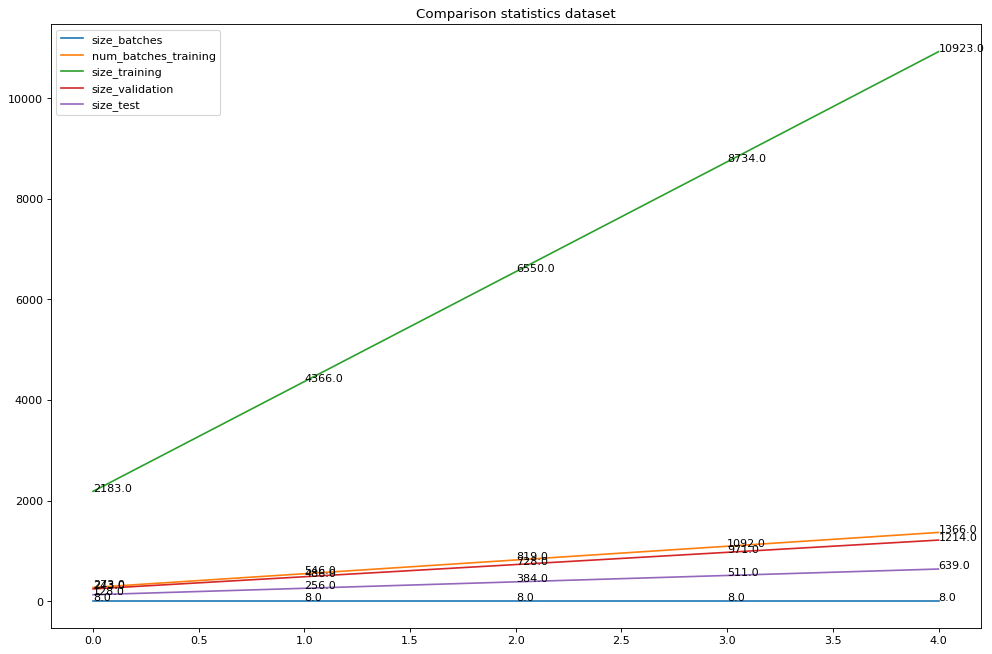

In [ ]:
#df_10_split.columns
columns_of_interest = ["size_batches", "num_batches_training", "size_training", 
                       "size_validation", "size_test"]
draw_statistics_spec_epoch(df_5_split, columns_of_interest, epoch=3, 
                           withLabelsInPlot=True, _title="Comparison statistics dataset",
                           showPlot=True, showScatter=True)

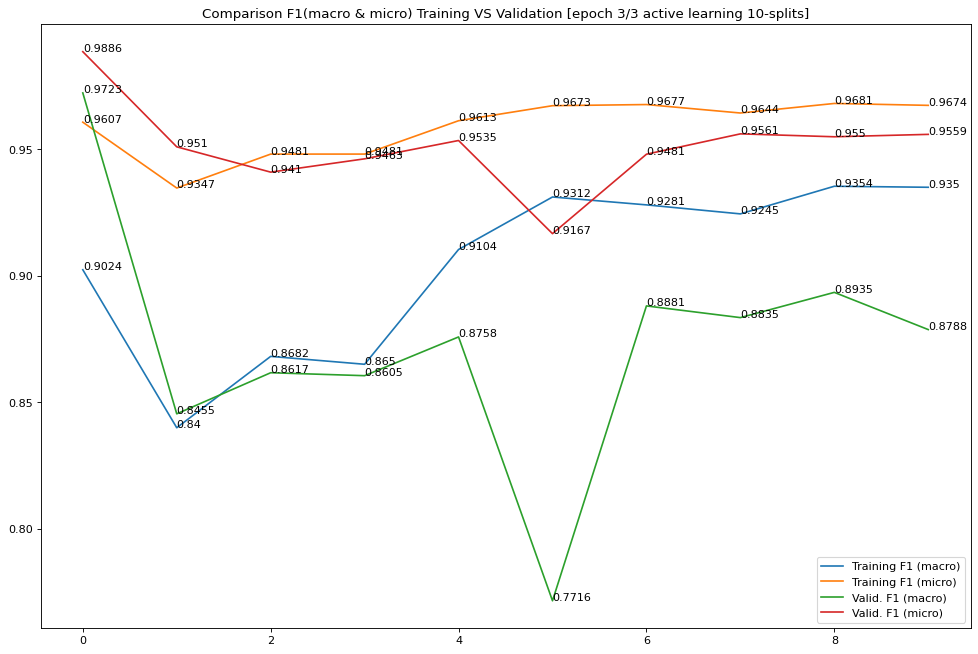

In [ ]:
columns_of_interest = ["Training F1 (macro)", "Training F1 (micro)",
                       "Valid. F1 (macro)", "Valid. F1 (micro)"]

draw_statistics_spec_epoch(df_10_split, columns_of_interest, epoch=3, 
                           withLabelsInPlot=True, _loc="lower right", 
                           showPlot=True, showScatter=True,
                           _title="Comparison F1(macro & micro) Training VS Validation [epoch 3/3 active learning 10-splits]")

In [ ]:
df_10_split.columns

Index(['epoch', 'Training Loss', 'Training Accur.',
       'Training Precision (macro)', 'Training Precision (micro)',
       'Training Recall (macro)', 'Training Recall (micro)',
       'Training F1 (macro)', 'Training F1 (micro)', 'Valid. Loss',
       'Valid. Accur.', 'Valid. Precision (macro)', 'Valid. Precision (micro)',
       'Valid. Recall (macro)', 'Valid. Recall (micro)', 'Valid. F1 (macro)',
       'Valid. F1 (micro)', 'Training Time', 'Validation Time', 'size_batches',
       'num_batches_training', 'size_training', 'size_validation',
       'size_test'],
      dtype='object')

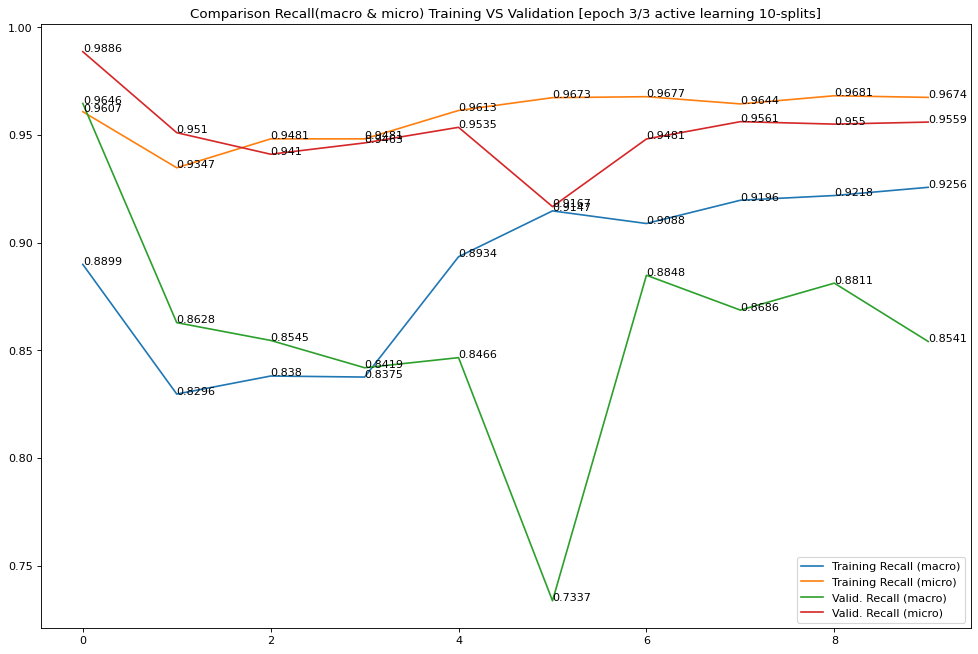

In [ ]:
columns_of_interest = ["Training Recall (macro)", "Training Recall (micro)",
                       "Valid. Recall (macro)", "Valid. Recall (micro)"]

draw_statistics_spec_epoch(df_10_split, columns_of_interest, epoch=3, 
                           withLabelsInPlot=True, _loc="lower right", 
                           showPlot=True, showScatter=True,
                           _title="Comparison Recall(macro & micro) Training VS Validation [epoch 3/3 active learning 10-splits]")

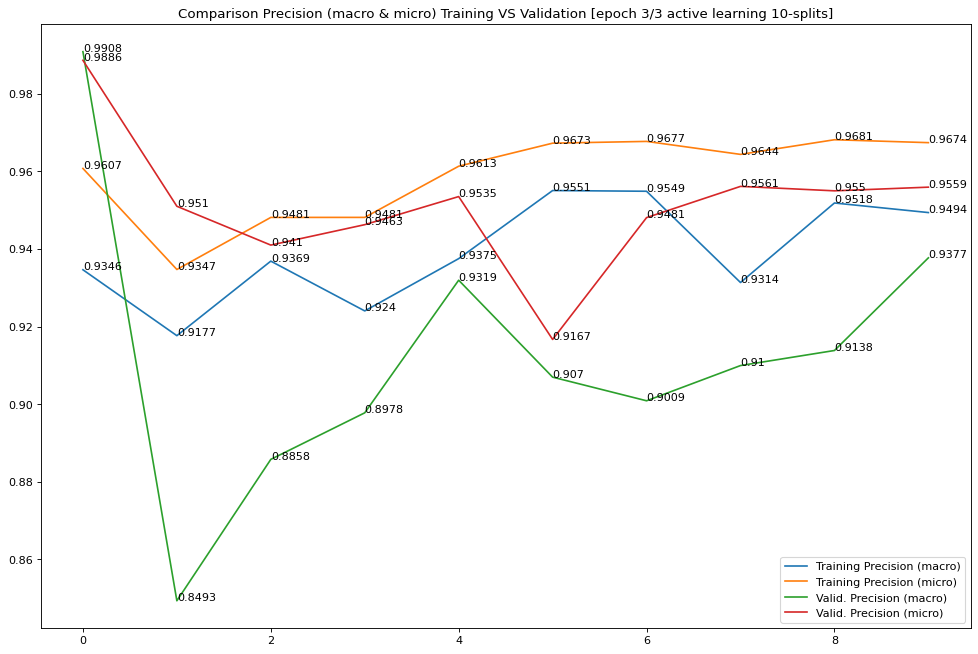

In [ ]:
columns_of_interest = ["Training Precision (macro)", "Training Precision (micro)",
                       "Valid. Precision (macro)", "Valid. Precision (micro)"]

draw_statistics_spec_epoch(df_10_split, columns_of_interest, epoch=3, 
                           withLabelsInPlot=True, _loc="lower right", 
                           showPlot=True, showScatter=True,
                           _title="Comparison Precision (macro & micro) Training VS Validation [epoch 3/3 active learning 10-splits]")